In [1]:
import pandas as pd
import numpy as np
from metrics import *
from matplotlib import pyplot as plt

In [2]:
class CustomDataset:
    def __init__(self, data, target):
        self.data = data
        self.target = target

In [13]:
def get_dataset(name='iris'):
    if name == 'iris':
        from sklearn.datasets import load_iris
        data = load_iris()
        return data
    if name == 'customer-amex':
        data = CustomDataset(
            pd.read_csv('../../data/customer-amex/train_data.csv', nrows=1000),
            pd.read_csv('../../data/customer-amex/train_labels.csv', nrows=1000)
        )
        return data
    if name == 'spotify':
        all_data = pd.read_csv('../../data/spotify/spotifyb.csv')
        all_data.drop(['count', 'artist', 'album', 'song', 'year', 'popularity', 'Unnamed: 0'], axis=1, inplace=True)
        indices = np.random.permutation(all_data.shape[0])
        data = CustomDataset(
            all_data.loc[indices[:2000], all_data.columns != 'genre'],
            all_data.loc[indices[:2000], all_data.columns == 'genre']
        )
        return data
    if name == 'seeds':
        all_data = pd.read_csv('../../data/seeds/seeds_dataset.txt', header=None)
        data = CustomDataset(
            all_data.loc[:, all_data.columns != 7].to_numpy(),
            all_data.loc[:, all_data.columns == 7].to_numpy().flatten()
        )
        return data

def get_tsne(X):
    from sklearn.manifold import TSNE
    X_embedded = TSNE(learning_rate='auto', init='random').fit_transform(X)
    return X_embedded

def get_plot(X, Y):
    data_embedded_combined = pd.DataFrame(data=np.c_[X, Y], columns=['x', 'y'] + ['target'])

    import seaborn as sbn
    sbn.scatterplot(data=data_embedded_combined, x='x', y='y', hue='target')
    plt.show()
    plt.close()

def perform_clustering(X, n_clusters):
    from sklearn.cluster import AgglomerativeClustering

    clustering = AgglomerativeClustering(n_clusters=n_clusters).fit(X)
    return clustering.labels_

def extrinsic_scores(labels, clusters):
    return {
        'adjusted_rand_index': adjusted_rand_index(labels, clusters),
        'adjusted_mutual_information': adjusted_mutual_information(labels, clusters)
    }

### Iris ###

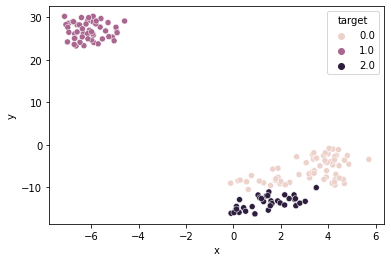

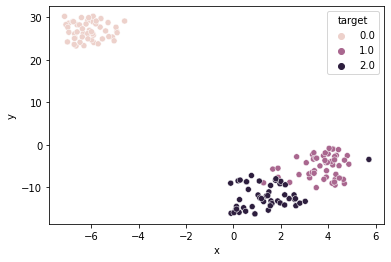

{'adjusted_rand_index': 0.7311985567707746, 'adjusted_mutual_information': 0.7671669615713113}


In [15]:
iris = get_dataset('iris')
X_iris = iris.data
Y_iris = iris.target
X_iris_embedded = get_tsne(X_iris)
clusters_iris = perform_clustering(X_iris, 3)
get_plot(X_iris_embedded, clusters_iris)
get_plot(X_iris_embedded, Y_iris)
print(extrinsic_scores(Y_iris, clusters_iris))

### Seeds ###

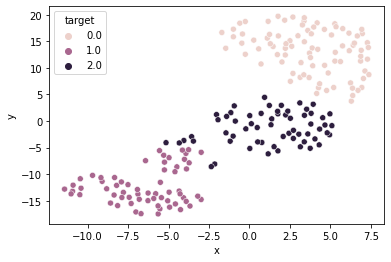

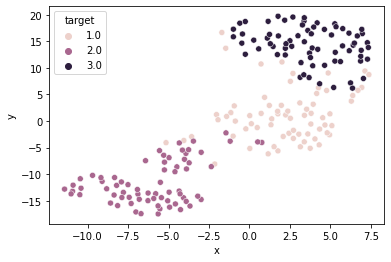

{'adjusted_rand_index': 0.7131537289031059, 'adjusted_mutual_information': 0.728523378387771}


In [16]:
seeds = get_dataset('seeds')
X_seeds = seeds.data
Y_seeds = seeds.target
X_seeds_embedded = get_tsne(X_seeds)
clusters_seeds = perform_clustering(X_seeds, 3)
get_plot(X_seeds_embedded, clusters_seeds)
get_plot(X_seeds_embedded, Y_seeds)
print(extrinsic_scores(Y_seeds, clusters_seeds))